In [1]:
import healpy as hp
import pandas as pd
import numpy as np
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
%matplotlib inline

In [2]:
p_centers = pd.read_csv('../patches/patches_centers6.csv')

In [3]:
p_centers.head()

,id,RAdeg,DEdeg
0,0,217.863483,66.544666
1,1,201.670396,59.717376
2,2,252.315480,78.270121
3,3,199.211097,69.733384
4,4,197.642895,64.562792


In [4]:
obj_data = pd.read_csv('/home/rt2122/data/Tile6.csv')

In [5]:
obj_data.head()

,id,objID,raStack,decStack,gPSFFlux,gPSFFluxErr,gKronFlux,gKronFluxErr,rPSFFlux,rPSFFluxErr,...,iKronFlux,iKronFluxErr,zPSFFlux,zPSFFluxErr,zKronFlux,zKronFluxErr,yPSFFlux,yPSFFluxErr,yKronFlux,yKronFluxErr
0,0,186832176591750093,217.659669,65.691098,1.046730e-06,5.391060e-07,-999.000000,-9.990000e+02,4.436980e-06,5.994010e-07,...,0.000005,5.220220e-07,0.000006,9.546940e-07,0.000005,0.000001,0.000007,0.000002,-999.000000,-999.000000
1,0,186822176482594779,217.648288,65.686693,-4.605090e-07,5.343210e-07,-999.000000,-9.990000e+02,4.506890e-07,5.864240e-07,...,0.000002,4.158390e-07,-0.000002,1.011970e-06,-999.000000,-999.000000,-0.000005,0.000002,-999.000000,-999.000000
2,0,186822176534472537,217.653415,65.684835,6.513790e-04,1.424520e-06,0.000599,1.308640e-06,9.205650e-04,1.304260e-06,...,0.000987,9.188920e-07,0.001111,2.045610e-06,0.001029,0.000002,0.001101,0.000003,0.001050,0.000005
3,0,186822176447373300,217.644680,65.685466,1.170660e-05,5.709810e-07,0.000011,7.019630e-07,2.941670e-05,5.933150e-07,...,0.000047,6.038840e-07,0.000064,1.114910e-06,0.000052,0.000001,0.000072,0.000002,0.000063,0.000003
4,0,186822176386036192,217.638514,65.687864,3.437700e-06,5.442620e-07,0.000004,6.909090e-07,5.152310e-06,6.314690e-07,...,0.000027,8.099850e-07,0.000018,1.050860e-06,0.000037,0.000002,0.000020,0.000002,0.000039,0.000004


In [6]:
obj_data.shape

(7460970, 24)

In [7]:
obj_data.drop_duplicates(subset = ['raStack', 'decStack'], keep='first', inplace=True)

In [8]:
obj_data.index = np.arange(obj_data.shape[0])
obj_data.index.max()

5519833

In [9]:
obj_data.shape

(5519834, 24)

In [10]:
def make_pic(center_pix, nside=2**11, size=64):
    def get_neighbours(npix, direction=None):
        theta, phi = hp.pix2ang(nside=nside, ipix=npix, nest=True)
        neighbours = hp.get_all_neighbours(nside=nside, theta=theta, phi=phi, nest=True)
        if direction is None:
            return neighbours
        dirs = ['sw', 'w', 'nw', 'n', 'ne', 'e', 'se', 's']
        return neighbours[dirs.index(direction)]
    
    ''' ~~~~~~~~~~> y 
      |  n __nw__ w
      |    |    |
    x | ne |    | sw
      |    |    |
      \/ e ~~se~~ s
         
    '''
    half = size // 2
    ans = np.ones((size, size), dtype=np.int32)
    ans *= -1
    ans[half - 1, half - 1] = center_pix
    for i in range(half - 2, -1, -1):
        ans[i, i] = get_neighbours(ans[i + 1, i + 1], 'n')
    for i in range(1, size):
        ans[i, 0] = get_neighbours(ans[i - 1, 0], 'se')
    for i in range(size):
        for j in range(1, size):
            if ans[i, j] == -1:
                ans[i, j] = get_neighbours(ans[i, j - 1], 'sw')
    return ans

In [11]:
def ra_dec2n_pix(ra, dec, nside):
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    theta = sc.galactic.l.degree
    phi = sc.galactic.b.degree
    npix = hp.ang2pix(nside=nside, nest=True, lonlat=True, theta = theta, phi = phi)
    return npix

In [12]:
pics_idx = []
for i in range(p_centers.shape[0]):
    npix = ra_dec2n_pix(p_centers.loc[i, 'RAdeg'], p_centers.loc[i, 'DEdeg'], 2**11)
    idx = make_pic(npix)
    pics_idx.append(idx) 

In [13]:
pics_idx = np.array(pics_idx)
pics_idx.shape

(50, 64, 64)

In [20]:
print(pics_idx[0, :8, :8])

[[7118303 7118302 7118299 7118298 7118287 7118286 7118283 7118282]
 [7118301 7118300 7118297 7118296 7118285 7118284 7118281 7118280]
 [7118295 7118294 7118291 7118290 7118279 7118278 7118275 7118274]
 [7118293 7118292 7118289 7118288 7118277 7118276 7118273 7118272]
 [7118207 7118206 7118203 7118202 7118191 7118190 7118187 7118186]
 [7118205 7118204 7118201 7118200 7118189 7118188 7118185 7118184]
 [7118199 7118198 7118195 7118194 7118183 7118182 7118179 7118178]
 [7118197 7118196 7118193 7118192 7118181 7118180 7118177 7118176]]


In [14]:
def show_pix(a, nside=2**11, matrix=False, one_colour=True):
    if matrix:
        a = a.reshape((a.shape[0] * a.shape[1]))
    m = np.zeros((hp.nside2npix(nside)), dtype=np.int32)
    i = 0
    for npix in a:
        vec = hp.pix2vec(nside=nside, ipix=npix, nest=True)
        ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(1), nest=True)
        m[ipix_disc] = 35
        if not one_colour:
            m[ipix_disc] += i
            i += 1
    hp.mollview(m, title="Mollview image NEST", nest=True)

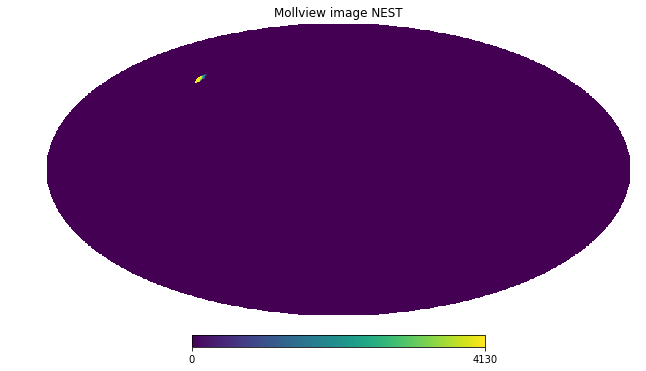

In [22]:
show_pix(pics_idx[0], matrix=True, one_colour=False)

In [30]:
pic = np.zeros(pics_idx.shape, dtype=np.float32)

In [16]:
obj_data['pix'] = None
for i in range(obj_data.shape[0]):
    if i % 1000 == 0:
        print(i, end=' ')
    ra = obj_data.loc[i, 'raStack']
    dec = obj_data.loc[i, 'decStack']
    pix = ra_dec2n_pix(ra, dec, 2**11)
    obj_data.loc[i, 'pix'] = pix

0 1000 2000 3000 4000 5000 6000 7000 

ValueError: Latitude angle(s) must be within -90 deg <= angle <= 90 deg, got -999.0 deg

In [18]:
obj_data = obj_data[obj_data['raStack'] != -999] 
obj_data = obj_data[obj_data['decStack'] != -999] 
obj_data.index = np.arange(obj_data.shape[0])

In [24]:
print(obj_data['raStack'].min(), obj_data['raStack'].max())
print(obj_data['decStack'].min(), obj_data['decStack'].max())

171.65407313 289.37138225
54.59786349 86.9075902


In [39]:
for i in range(70, obj_data.shape[0] // 100):
    print(i)
    st = i * 100
    en = st + 100
    ra = obj_data.loc[st:en - 1, 'raStack']
    dec = obj_data.loc[st:en - 1, 'decStack']
    pix = ra_dec2n_pix(ra, dec, 2**11)
    for j in range(st, en):
        obj_data.loc[i, 'pix'] = pix[j - st]

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


KeyboardInterrupt: 

In [43]:
from tqdm import tqdm_notebook

In [44]:
for i in tqdm_notebook(range(85, obj_data.shape[0] // 100)):
    st = i * 100
    en = st + 100
    ra = obj_data.loc[st:en - 1, 'raStack']
    dec = obj_data.loc[st:en - 1, 'decStack']
    pix = ra_dec2n_pix(ra, dec, 2**11)
    for j in range(st, en):
        obj_data.loc[i, 'pix'] = pix[j - st]

KeyboardInterrupt: 

In [60]:
for i in range(pics_idx.shape[0]):
    print(i)
    obj_i = obj_data[obj_data['id'] == i]
    obj_i.index = np.arange(obj_i.shape[0])
    for j in range(obj_i.shape[0]):
        ra = obj_i.loc[j]['raStack']
        dec = obj_i.loc[j]['decStack']
        if ra == -999 or dec == -999:
            continue
        obj_pix = ra_dec2n_pix(ra, dec, 2**11)
        location = np.where(pics_idx == obj_pix)
        if len(location[0]) > 0:
            x = location[0][0]
            y = location[1][0]
            pic[i, x, y] = max(obj_i.loc[j, 'gPSFFlux'], pic[i, x, y])

0


KeyboardInterrupt: 

In [32]:
a = np.array([[1, 2], [1, 3]])
print(np.where(a == 4))

(array([], dtype=int64), array([], dtype=int64))


In [45]:
obj_data.index.max()

7460969

In [57]:
obj_data['raStack'].min(), obj_data['raStack'].max()

(-999.0, 289.37138225)

In [58]:
obj_data['decStack'].min(), obj_data['decStack'].max()

(-999.0, 86.9075902)

In [25]:
p_centers.loc[4:10]

,id,RAdeg,DEdeg
4,4,197.642895,64.562792
5,5,213.963497,55.597838
6,6,214.042863,59.714255
7,7,238.355351,67.105606
8,8,207.740964,74.736210
9,9,264.396481,85.907761
10,10,180.473875,73.119855


In [34]:
len(obj_data.loc[8000:8005]) 

6

In [36]:
len([-1] * len(obj_data.loc[8000:8005]) )

6

In [45]:
obj_data.to_csv('~/data/Tile6_edited.csv')